# Chapter 5 - Resampling Methods

In [34]:
import collections
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy as pt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    # for scikit-learn prior to 0.18
    from sklearn.cross_validation import train_test_split

### 5. In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

In [4]:
default = pd.read_csv('./Datasets/Default.csv', index_col=0)
default = pd.get_dummies(default, drop_first=True)
default_y, default_X = pt.dmatrices('default_Yes ~ income + balance - 1', default)
default_y = default_y.ravel()

(a) Fit a logistic regression model that uses income and balance to predict default 

In [5]:
d_lr_model = LogisticRegression()

(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:  
i. Split the sample set into a training set and a validation set.



In [6]:
default_X_train, default_X_test, default_y_train, default_y_test = train_test_split(default_X, 
                                                                                    default_y,
                                                                                    test_size=0.2,
                                                                                    random_state=777)

ii. Fit a multiple logistic regression model using only the training observations.


In [7]:
d_lr_model.fit(default_X_train, default_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.


In [8]:
default_cv_prediction = d_lr_model.predict(default_X_test)

iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [9]:
print('Validation set error is {:.2%}'.format(1-d_lr_model.score(default_X_test, default_y_test)))

Validation set error is 3.75%


(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

In [10]:
default_test_errors = []
for _ in range(3):
    default_X_train, default_X_test, default_y_train, default_y_test = train_test_split(default_X, 
                                                                                    default_y,
                                                                                    test_size=0.2,
                                                                                    random_state=100*_)
    model = LogisticRegression()
    model.fit(default_X_train, default_y_train)
    test_error = 1 - model.score(default_X_test, default_y_test)
    default_test_errors.append(test_error)
print('Validation set errors for 3 different splits are {}'.format(default_test_errors))

Validation set errors for 3 different splits are [0.037000000000000033, 0.032499999999999973, 0.025000000000000022]


(d) Now consider a logistic regression model that predicts the probability of default using income , balance , and a dummy variable for student . Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [11]:
default_X = pt.dmatrix('balance + income + student_Yes - 1', default)
default_X_train, default_X_test, default_y_train, default_y_test = train_test_split(default_X, 
                                                                                    default_y,
                                                                                    test_size=0.2,
                                                                                    random_state=777)
d_lr_model.fit(default_X_train, default_y_train)
print('Validation set error for model with student predictor is {:.2%}'.format(1-d_lr_model.score(default_X_test, default_y_test)))

Validation set error for model with student predictor is 3.75%


Including student dummy variable have no effect on test error given all else equal.

### 6. We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the glm() function. Do not forget to set a random seed before beginning your analysis.

#### For this excercise I will use statsmodels package to have inference from model.

(a) Using the summary() and glm() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

In [12]:
d_lr_model_sm = smf.logit('default_Yes ~ income + balance', data=default).fit()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


In [13]:
d_lr_model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 15 Dec 2016   Pseudo R-squ.:                  0.4594
Time:                        19:19:51   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000       -12.393   -10.688
income      2.081e-05   4.99e-06      4.174      0.000       1.1e-05  3.06e-05
balance        0.0056      0.000     24.835      0.000         0.005     0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

(b) Write a function, boot.fn() , that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [14]:
def boot_fn(data, obs_ind):
    model = smf.logit('default_Yes ~ income + balance', data=data.ix[obs_ind]).fit(disp=False)
    return model.bse[1:]

In [15]:
def boot(data, bn=100):
    pars = [0, 0]
    n = len(data)
    for _ in range(bn):
        obs_ind = np.random.choice(data.index, size=n)
        pars += boot_fn(data, obs_ind)

    pars /= bn
    return pars

(c) Use the boot() function together with your boot.fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.

In [16]:
print('Std. errors predicted with logistic regression model:\n {}, std. errors predicted with bootstrap:\n {}'.format(d_lr_model_sm.bse[1:], boot(default)))

Std. errors predicted with logistic regression model:
 income     0.000005
balance    0.000227
dtype: float64, std. errors predicted with bootstrap:
 income     0.000005
balance    0.000228
dtype: float64


(d) Comment on the estimated standard errors obtained using the glm() function and using your bootstrap function.  
Estimates are almost equal for both methods.

### 7. In Sections 5.3.2 and 5.3.3, we saw that the cv.glm() function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just the glm() and predict.glm() functions, and a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the Weekly data set. Recall that in the context of classification problems, the LOOCV error is given in (5.4).

In [17]:
weekly = pd.read_csv('./Datasets/Weekly.csv', index_col=0)
weekly = pd.get_dummies(weekly, drop_first=True)

(a) Fit a logistic regression model that predicts Direction using Lag1 and Lag2.

In [18]:
weekly_y, weekly_X = pt.dmatrices('Direction_Up ~ Lag1 + Lag2 - 1', weekly)
weekly_y = weekly_y.ravel()
dir_lr_model_full = LogisticRegression()
dir_lr_model_full.fit(weekly_X, weekly_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

(b) Fit a logistic regression model that predicts Direction using Lag1 and Lag2 using all but the first observation.

In [19]:
dir_lr_model_foo = LogisticRegression()
dir_lr_model_foo.fit(weekly_X[1:], weekly_y[1:])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

(c) Use the model from (b) to predict the direction of the first observation. You can do this by predicting that the first observation will go up if P( Direction="Up" | Lag1 , Lag2 ) > 0.5. Was this observation correctly classified?

In [20]:
dir_lr_model_foo.predict(weekly_X[0].reshape(1, -1)) == weekly_y[0]

array([False], dtype=bool)

d) Write a for loop from i = 1 to i = n, where n is the number of observations in the data set, that performs each of the following steps:  
i. Fit a logistic regression model using all but the ith observation to predict Direction using Lag1 and Lag2.  
ii. Compute the posterior probability of the market moving up for the ith observation.  
iii. Use the posterior probability for the ith observation in order to predict whether or not the market moves up.  
iv. Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.  
(e) Take the average of the n numbers obtained in (d)iv in order to obtain the LOOCV estimate for the test error. Comment on the results.  

In [21]:
total_misclassified = 0
idx = np.arange(len(weekly))
for i in range(len(weekly)):
    model = LogisticRegression()
    model.fit(weekly_X[idx != i], weekly_y[idx != i])
    total_misclassified += model.predict(weekly_X[i].reshape(1, -1))[0] != weekly_y[i]

print('LOOCV average test error is {:.2%}'.format(total_misclassified / len(weekly)))

LOOCV average test error is 45.00%


### 8. We will now perform cross-validation on a simulated data set.(a) Generate a simulated data set as follows:  
```r
set.seed(1)  
y=rnorm(100)  
x=rnorm(100)  
y=x-2*x^2+rnorm(100)  
```
In this data set, what is n and what is p? Write out the model used to generate the data in equation form.  
n=100  
p=1  
$Y=X-2X^2+\epsilon$

In [22]:
np.random.seed(1)
y = np.random.randn(100)
x = np.random.randn(100)
y = x - 2*x**2 + np.random.randn(100)

(b) Create a scatterplot of X against Y . Comment on what you find.  
We can see a strong nonlinear relation ship between $x$ and $y$.

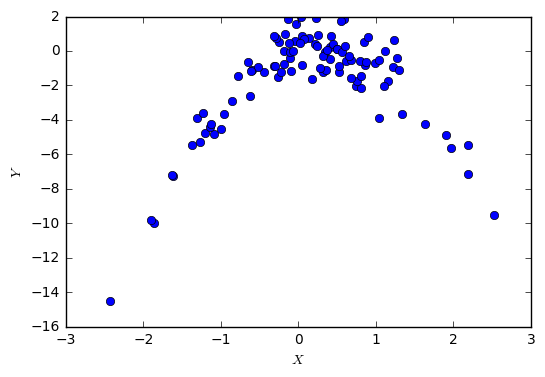

In [23]:
plt.plot(x, y, 'bo')
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.show()

(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:  

i.$ Y = β_0 + β_1X + \epsilon$  
ii. $Y = β_0 + β_1X + β_2 X^2 + \epsilon$  
iii. $Y = β_0 + β_1X + β_2X^2 + β 3X^3 + \epsilon$  
iv. $Y = β_0 + β_1X + β_2X^2 + β_3X^3 + β_4X^4 + \epsilon$

In [24]:
df = pd.DataFrame({'y': y, 'x': x})

In [25]:
models = collections.OrderedDict((('i', 'y ~ x'),
         ('ii', 'y ~ x + np.power(x, 2)'),
         ('iii', 'y ~ x + np.power(x, 2) + np.power(x, 3)'),
         ('iv', 'y ~ x + np.power(x, 2) + np.power(x, 3) + np.power(x, 4)')))

In [26]:
n = len(df)
idx = df.index
for m in models:
    loocv_error = 0
    df['loocv_pred_' + m] = np.nan
    for i in idx:
        ols = smf.ols(models[m], df[idx!=i]).fit()
        df.ix[i, 'loocv_pred_' + m] = ols.predict(df.ix[i])
    print('LOOCV error for model {} is {:.2%}'.format(m, mean_squared_error(df.y, df['loocv_pred_' + m])))

LOOCV error for model i is 829.22%
LOOCV error for model ii is 101.71%
LOOCV error for model iii is 104.66%
LOOCV error for model iv is 105.75%


(d) Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?

In [27]:
np.random.seed(777)
y = np.random.randn(100)
x = np.random.randn(100)
y = x - 2*x**2 + np.random.randn(100)
df = pd.DataFrame({'y': y, 'x': x})
n = len(df)
idx = df.index
last_model = {}
for m in models:
    loocv_error = 0
    df['loocv_pred_' + m] = np.nan
    for i in idx:
        ols = smf.ols(models[m], df[idx!=i]).fit()
        df.ix[i, 'loocv_pred_' + m] = ols.predict(df.ix[i])
    last_model[m] = ols
    print('LOOCV error for model {} is {:.2%}'.format(m, mean_squared_error(df.y, df['loocv_pred_' + m])))

LOOCV error for model i is 883.32%
LOOCV error for model ii is 93.53%
LOOCV error for model iii is 96.80%
LOOCV error for model iv is 94.78%


(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.  

Model with smallest LOOCV error is the second one. I expected this model to have lowest error, becaus true functional form of y is parabolic, so second model fit linear regression with quadratic form of predictor thus giving us the best fit.

(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?  

In [28]:
for m in models:
    print('Model {}. {}'.format(m, models[m]))
    print('-' * 80)
    model_loocv = last_model[m]
    train, test = train_test_split(df, test_size=0.2, random_state=777)
    model_cv = smf.ols(models[m], train).fit()
    print('\tLOOCV model coefficients:\n{}'.format(model_loocv.params))
    print('\tCV model coefficients:\n{}'.format(model_cv.params))
    print(':' * 80)
    print('\tLOOCV model p-values:\n{}'.format(model_loocv.pvalues))
    print('\tCV model p-values:\n{}'.format(model_cv.pvalues))
    print('\n')

Model i. y ~ x
--------------------------------------------------------------------------------
	LOOCV model coefficients:
Intercept   -1.899290
x            1.068648
dtype: float64
	CV model coefficients:
Intercept   -2.157402
x            1.217548
dtype: float64
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
	LOOCV model p-values:
Intercept    2.192028e-09
x            5.771150e-04
dtype: float64
	CV model p-values:
Intercept    1.583882e-08
x            5.394237e-04
dtype: float64


Model ii. y ~ x + np.power(x, 2)
--------------------------------------------------------------------------------
	LOOCV model coefficients:
Intercept         0.020748
x                 0.901478
np.power(x, 2)   -2.079650
dtype: float64
	CV model coefficients:
Intercept        -0.003267
x                 0.960084
np.power(x, 2)   -2.076126
dtype: float64
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
	LOOCV model p-values:
Intercept     

For model i and ii all coefficients are significant. In model iii coefficient $\hat{\beta}_3$ is not significant, according to p-value. In model iv all coefficients are significant.  
Models fitted using cross validation have almost the same results as LOOCV, except model iv, in which both $\hat{\beta}_3$ and $\hat{\beta}_4$ are not significant.

### 9. We will now consider the Boston housing data set, from the MASS library.  
(a) Based on this data set, provide an estimate for the population mean of medv . Call this estimate $\hat{μ}$.

In [29]:
boston = pd.read_csv('./Datasets/Boston.csv', index_col=0)

In [30]:
mu_hat = boston.medv.mean()

(b) Provide an estimate of the standard error of $\hat{μ}$. Interpret this result.  
*Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.*  
$se_{\hat{\mu}} = \sigma_{medv}/\sqrt{n}$

In [31]:
se_mu_hat = boston.medv.std() / np.sqrt(len(boston))
se_mu_hat

0.4088611474975351

(c) Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from (b)?

In [32]:
mu_bs = []
for _ in range(1000):
    mu_bs.append(np.random.choice(boston.medv, size=len(boston)).mean())
se_mu_bs = np.std(mu_bs)
se_mu_bs

0.40974288676860715

Standard error of $\hat{\mu}$ is very close to value obtained by calculation in (b).

(d) Based on your bootstrap estimate from (c), provide a 95% confidence interval for the mean of medv. Compare it to the results obtained using t.test(Boston\$medv).  
*Hint: You can approximate a 95% confidence interval using the formula - $[\hat{μ} − 2SE(\hat{μ}), \hat{μ} + 2SE(\hat{μ})]$.*

In [33]:
print('Confidence interval based on bootstrap estimate of std error is [{}, {}]'.format(mu_hat-2*se_mu_bs, mu_hat+2*se_mu_bs))

Confidence interval based on bootstrap estimate of std error is [21.713320550573485, 23.35229209764791]


In [39]:
sp.stats.ttest_1samp(boston.medv, 0)

Ttest_1sampResult(statistic=55.111145830373921, pvalue=9.3706237271326624e-216)

With 95% confidence we can reject null hypothesis that sample mean is equal zero. We obtained same result with confidence interval.

(e) Based on this data set, provide an estimate, $\hat{\mu}_{med}$ , for the median value of medv in the population.

In [40]:
mu_med_hat = boston.medv.median()

(f) We now would like to estimate the standard error of $\hat{\mu}_{med}$ . Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

In [42]:
mu_med_bs = []
for _ in range(1000):
    mu_med_bs.append(np.median(np.random.choice(boston.medv, size=len(boston))))
se_mu_med_bs = np.std(mu_med_bs)
se_mu_med_bs

0.38231505005688665

(g) Based on this data set, provide an estimate for the tenth percentile of medv in Boston suburbs. Call this quantity $\hat{\mu}_{0.1}$. (You can use the quantile() function.)

In [43]:
mu_01_hat = boston.medv.quantile(0.1)

(h) Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.  
Standard error for 10th percentile is close to standard error to 50th percentile (median).

In [47]:
mu_01_bs = []
for _ in range(1000):
    sample = np.random.choice(boston.medv, size=len(boston))
    mu_01_bs.append(np.percentile(sample, 10))
se_mu_01_bs = np.std(mu_01_bs)
se_mu_01_bs

0.48383235733051166